In [22]:
import json
import os
from pathlib import Path

import matplotlib 
matplotlib.rcParams['font.family'] = ['Noto Serif CJK JP']
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve


In [23]:
ROOT = Path('/home/kylehiroyasu/programming/masters_thesis/stochastic-YOLO/results_21_09_2021')

In [24]:
files = [f for f in os.listdir(ROOT) if 'csv' in f]
files.sort()
files

['all_test_results.csv',
 'ccpd.csv',
 'ccpd_blur.csv',
 'ccpd_blur_dropout.csv',
 'ccpd_blur_ensemble.csv',
 'ccpd_challenge.csv',
 'ccpd_challenge_dropout.csv',
 'ccpd_challenge_ensemble.csv',
 'ccpd_db.csv',
 'ccpd_db_dropout.csv',
 'ccpd_db_ensemble.csv',
 'ccpd_dropout.csv',
 'ccpd_ensemble.csv',
 'ccpd_fn.csv',
 'ccpd_fn_dropout.csv',
 'ccpd_fn_ensemble.csv',
 'ccpd_rotate.csv',
 'ccpd_rotate_dropout.csv',
 'ccpd_rotate_ensemble.csv',
 'ccpd_tilt.csv',
 'ccpd_tilt_dropout.csv',
 'ccpd_tilt_ensemble.csv',
 'ccpd_weather.csv',
 'ccpd_weather_dropout.csv',
 'ccpd_weather_ensemble.csv']

In [25]:
files = [
    'ccpd_blur.csv',
    'ccpd_blur_dropout.csv',
    'ccpd_blur_ensemble.csv',
    'ccpd_challenge.csv',
    'ccpd_challenge_dropout.csv',
    'ccpd_challenge_ensemble.csv',
    'ccpd_db.csv',
    'ccpd_db_dropout.csv',
    'ccpd_db_ensemble.csv',
    'ccpd_fn.csv',
    'ccpd_fn_dropout.csv',
    'ccpd_fn_ensemble.csv',
    'ccpd_rotate.csv',
    'ccpd_rotate_dropout.csv',
    'ccpd_rotate_ensemble.csv',
    'ccpd_tilt.csv',
    'ccpd_tilt_dropout.csv',
    'ccpd_tilt_ensemble.csv',
    'ccpd.csv',
    'ccpd_dropout.csv',
    'ccpd_ensemble.csv',
    'ccpd_weather.csv',
    'ccpd_weather_dropout.csv',
    'ccpd_weather_ensemble.csv'
]

In [26]:
groups = ['blur', 'challenge', 'db', 'fn', 'rotate', 'tilt', 'val']
groups = ['Blur', 'Challenge', 'DB', 'FN', 'Rotate', 'Tilt', 'Base', 'Weather']

In [27]:
def load_data(path: str):
    all_predictions = []
    with open(path, mode='r') as f:
        for line in f.readlines():
            prediction = json.loads(line)
            for correct, confidence, bbv, entropy in zip(prediction['correct'], prediction['confidence'], prediction['bounding_box_variance'], prediction['entropy']):
                data = {
                    'image_name': prediction['image_name'],
                    'correct': correct[0],
                    'confidence': confidence,
                    'bounding_box_variance':bbv,
                    'entropy': entropy
                }
                all_predictions.append(data)
    return pd.DataFrame(all_predictions)

In [28]:
def plot_calibration_curve(data_dict: dict, dataset_name: str,  fig_index):


    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, df in data_dict.items():
        y_test = df.correct
        prob_pos = df.confidence
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        #print("%s:" % name)
        #print("\tBrier: %1.3f" % (clf_score))
        #print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        #print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        #print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        # ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
        #          label="%s (%1.3f)" % (name, clf_score))
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label=name)

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plots {dataset_name} (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_detection.svg')

In [29]:
datasets = []
for i in range(0, len(files), 3):
    data = load_data(ROOT/files[i])
    dropout_data = load_data(ROOT/files[i+1])
    ensemble_data = load_data(ROOT/files[i+2])
    datasets.append({
        'Normal': data,
        'MC-Dropout (10 samples)': dropout_data,
        'Ensemble (N=3)': ensemble_data
    })

In [30]:
all_results = []
for group, data in zip(groups, datasets):
    for k, df in data.items():
        df['model'] = k
        df['dataset'] = group
        all_results.append(df)
dataset_results = pd.concat(all_results)


In [31]:
mean_results = dataset_results.groupby(by=['dataset','model']).mean()
mean_results

correct  confidence  \
dataset   model                                           
Base      Ensemble (N=3)           0.805335    0.628396   
          MC-Dropout (10 samples)  0.696002    0.539944   
          Normal                   0.747835    0.582472   
Blur      Ensemble (N=3)           0.806826    0.552305   
          MC-Dropout (10 samples)  0.735134    0.493192   
          Normal                   0.784773    0.529958   
Challenge Ensemble (N=3)           0.718796    0.503189   
          MC-Dropout (10 samples)  0.628275    0.432553   
          Normal                   0.681758    0.472181   
DB        Ensemble (N=3)           0.769503    0.566265   
          MC-Dropout (10 samples)  0.710894    0.514252   
          Normal                   0.759336    0.552544   
FN        Ensemble (N=3)           0.698929    0.454159   
          MC-Dropout (10 samples)  0.558795    0.356370   
          Normal                   0.701195    0.450136   
Rotate    Ensemble (N=3)           0.636052    0.495577   
          MC-Dropout (10 samples)  0.553442    0.426062   
          Normal                   0.615068    0.476609   
Tilt      Ensemble (N=3)           0.650559    0.504435   
          MC-Dropout (10 samples)  0.560029    0.428515   
          Normal                   0.630304    0.485913   
Weather   Ensemble (N=3)           0.840676    0.652057   
          MC-Dropout (10 samples)  0.736195    0.567790   
          Normal                   0.787137    0.609610   

                                   bounding_box_variance   entropy  
dataset   model                                                     
Base      Ensemble (N=3)                        1.373124  0.394577  
          MC-Dropout (10 samples)              66.807804  0.347908  
          Normal                                0.000000  0.368746  
Blur      Ensemble (N=3)                        3.301966  0.445959  
          MC-Dropout (10 samples)              53.107179  0.414573  
          Normal                                0.000000  0.436103  
Challenge Ensemble (N=3)                        2.041573  0.391760  
          MC-Dropout (10 samples)              47.138309  0.350353  
          Normal                                0.000000  0.372795  
DB        Ensemble (N=3)                        5.116936  0.436746  
          MC-Dropout (10 samples)              88.806370  0.410298  
          Normal                                0.000000  0.431445  
FN        Ensemble (N=3)                        6.943384  0.408438  
          MC-Dropout (10 samples)             326.439194  0.334527  
          Normal                                0.000000  0.405921  
Rotate    Ensemble (N=3)                        2.386140  0.309292  
          MC-Dropout (10 samples)              92.699911  0.276798  
          Normal                                0.000000  0.301242  
Tilt      Ensemble (N=3)                        2.686084  0.319828  
          MC-Dropout (10 samples)             110.320862  0.282847  
          Normal                                0.000000  0.311007  
Weather   Ensemble (N=3)                        1.286196  0.413978  
          MC-Dropout (10 samples)              82.337003  0.369146  
          Normal                                0.000000  0.389834

<AxesSubplot:ylabel='dataset,model'>

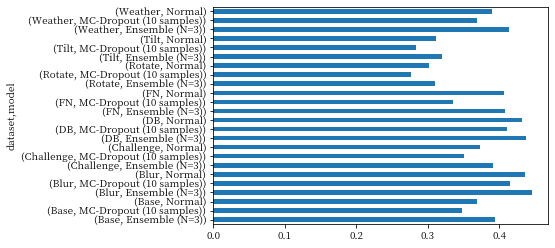

In [32]:
mean_results.entropy.plot.barh()

In [33]:
summary = pd.read_csv(ROOT/'all_test_results.csv', index_col=0)
dataset = {
    'ccpd_blur.data': 'Blur', 
    'ccpd_challenge.data': 'Challenge', 
    'ccpd_db.data': 'DB',
    'ccpd_fn.data': 'FN', 
    'ccpd_rotate.data': 'Rotate', 
    'ccpd_tilt.data': 'Tilt', 
    'ccpd.data': 'Base',
    'ccpd_weather.data':'Weather'
}
model = {
    'ensemble': 'Ensemble (N=3)',
    'dropout': 'MC-Dropout (10 samples)',
    'normal': 'Normal'
}
rename_columns = ['Data', 'do', 'Model','MP', 'MR', 'MAP', 'MF1']
summary.columns = rename_columns
summary['Data'] = summary.Data.apply(lambda d: dataset[d])
summary['Model'] = summary.Model.apply(lambda d: model[d])
summary_piv = summary.pivot(index='Model', columns='Data', values='MAP')
summary_piv

Data,Base,Blur,Challenge,DB,FN,Rotate,Tilt,Weather
Model,,,,,,,,
Ensemble (N=3),0.994945,0.967480,0.989675,0.926514,0.959563,0.992936,0.992300,0.994977
MC-Dropout (10 samples),0.994944,0.966100,0.987924,0.924164,0.957621,0.993072,0.991959,0.994973
Normal,0.994941,0.966124,0.988133,0.925592,0.959174,0.992858,0.992166,0.994977


In [34]:
print(summary_piv.to_latex(float_format="%0.3f"))

\begin{tabular}{lrrrrrrrr}
\toprule
Data &  Base &  Blur &  Challenge &    DB &    FN &  Rotate &  Tilt &  Weather \\
Model                   &       &       &            &       &       &         &       &          \\
\midrule
Ensemble (N=3)          & 0.995 & 0.967 &      0.990 & 0.927 & 0.960 &   0.993 & 0.992 &    0.995 \\
MC-Dropout (10 samples) & 0.995 & 0.966 &      0.988 & 0.924 & 0.958 &   0.993 & 0.992 &    0.995 \\
Normal                  & 0.995 & 0.966 &      0.988 & 0.926 & 0.959 &   0.993 & 0.992 &    0.995 \\
\bottomrule
\end{tabular}



In [35]:
results = mean_results.reset_index()
results['id'] = results.dataset + results.model

In [36]:
summary
summary['id'] = summary.Data + summary.Model

In [37]:
merged = pd.merge(summary, results, on='id')
merged

,Data,do,Model,MP,MR,MAP,MF1,id,dataset,model,correct,confidence,bounding_box_variance,entropy
0,Blur,False,Ensemble (N=3),0.981640,0.954631,0.967480,0.967947,BlurEnsemble (N=3),Blur,Ensemble (N=3),0.806826,0.552305,3.301966,0.445959
1,Blur,False,Normal,0.980295,0.942652,0.966124,0.961105,BlurNormal,Blur,Normal,0.784773,0.529958,0.000000,0.436103
2,Blur,True,MC-Dropout (10 samples),0.979760,0.945854,0.966100,0.962509,BlurMC-Dropout (10 samples),Blur,MC-Dropout (10 samples),0.735134,0.493192,53.107179,0.414573
3,Challenge,False,Ensemble (N=3),0.990240,0.979997,0.989675,0.985092,ChallengeEnsemble (N=3),Challenge,Ensemble (N=3),0.718796,0.503189,2.041573,0.391760
4,Challenge,False,Normal,0.990233,0.973254,0.988133,0.981670,ChallengeNormal,Challenge,Normal,0.681758,0.472181,0.000000,0.372795
5,Challenge,True,MC-Dropout (10 samples),0.989385,0.974888,0.987924,0.982083,ChallengeMC-Dropout (10 samples),Challenge,MC-Dropout (10 samples),0.628275,0.432553,47.138309,0.350353
6,DB,False,Ensemble (N=3),0.948153,0.934268,0.926514,0.941159,DBEnsemble (N=3),DB,Ensemble (N=3),0.769503,0.566265,5.116936,0.436746
7,DB,False,Normal,0.949644,0.926924,0.925592,0.938146,DBNormal,DB,Normal,0.759336,0.552544,0.000000,0.431445
8,DB,True,MC-Dropout (10 samples),0.947291,0.928050,0.924164,0.937572,DBMC-Dropout (10 samples),DB,MC-Dropout (10 samples),0.710894,0.514252,88.806370,0.410298
9,FN,False,Ensemble (N=3),0.970165,0.963123,0.959563,0.966631,FNEnsemble (N=3),FN,Ensemble (N=3),0.698929,0.454159,6.943384,0.408438


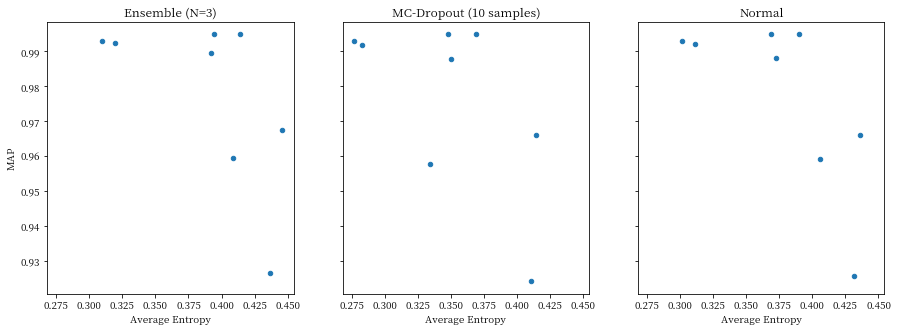

In [38]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey='row', figsize=(15,5))

for i, (name, group) in enumerate(merged.groupby(by='Model')):
    group.plot.scatter(x='entropy', y='MAP',xlabel='Average Entropy', ax=axs[i])
    axs[i].set_title(name)
plt.savefig(f'map_vs_entropy.svg')


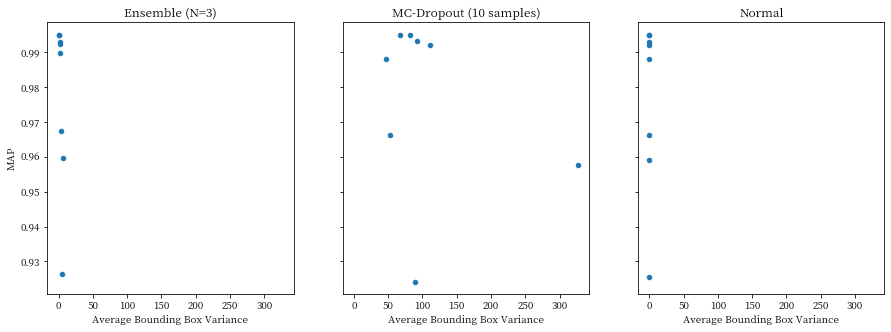

In [39]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey='row', figsize=(15,5))

for i, (name, group) in enumerate(merged.groupby(by='Model')):
    group.plot.scatter(x='bounding_box_variance', y='MAP',xlabel='Average Bounding Box Variance', ax=axs[i])
    axs[i].set_title(name)
plt.savefig(f'map_vs_variance.svg')


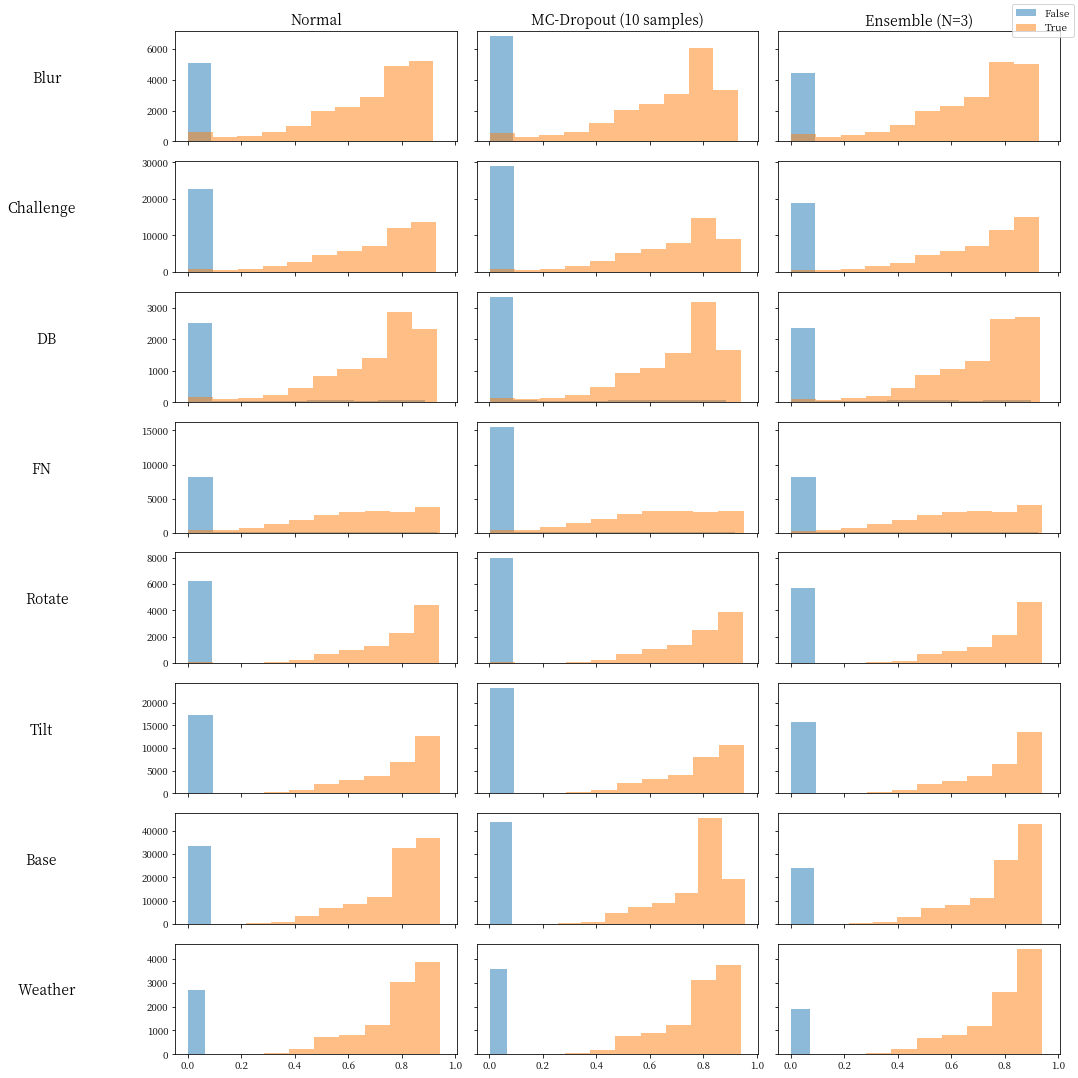

In [40]:
#fig = plt.figure(figsize=(20, 20))
#axes.Axes(fig, (0,0,3,8), sharex=True)
fig, axs = plt.subplots(len(groups), 3, sharex=True, sharey='row', figsize=(15,15))

for i, (name, data_dict) in enumerate(zip(groups, datasets)):
    for j, (key, df) in enumerate(data_dict.items()):
        #df.groupby(by=['correct'])['entropy'].plot.hist(bins=10, ax=axs[i,j], alpha=.5)
        df.groupby(by=['correct'])['confidence'].plot.hist(bins=10, ax=axs[i,j], alpha=.5)

for i, k in enumerate(data_dict.keys()):
    axs[0, i].set_title(k, fontsize=14)
    
for i, k in enumerate(groups):
    axs[i, 0].set_ylabel(k, rotation=0, fontsize=14, labelpad=100)
    
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper right')

plt.tight_layout()
plt.savefig(f'detection_hist.svg')
plt.show()

In [41]:
def plot_calibration_curve(data_dict: dict, dataset_name: str,  ax1):

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, df in data_dict.items():
        y_test = df.correct
        prob_pos = df.confidence
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label=name)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Predicted Probability")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title(f'{dataset_name}')
    



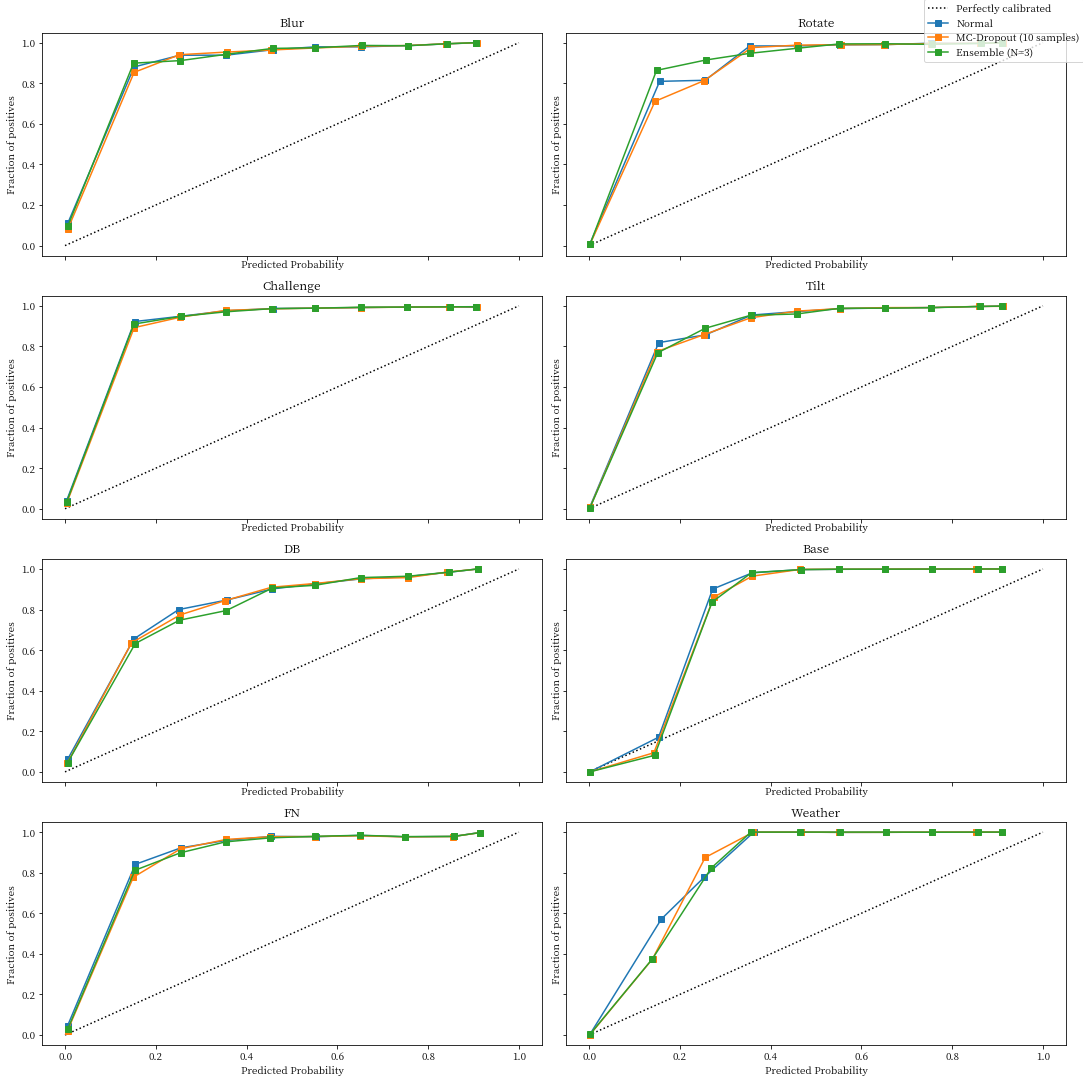

In [42]:
fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(15,15))

for i, (name, data_dict) in enumerate(zip(groups, datasets)):
    row = i % 4
    col = int(i/4)
    plot_calibration_curve(data_dict=data_dict, dataset_name=name, ax1=axs[row, col])

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper right',borderaxespad=0.)
fig


plt.tight_layout()
plt.savefig(f'detection_calibration.svg')